# Pulling and Visualizing Cryptocurrency Data from BraveNewCoin's Mashable API
## *Edward Krueger*

This notebook contains some functions for pulling data from BraveNewCoin's API on Mashable/Kong into a ```pandas```. It uses the ```requests``` package to handle requests and visualizes the data with ```matplotlib```.

I have omitted the API key due to Mashape's licensing. The user should please replace the string "MY_SUPER_SECRET_KEY" with thier own if they have access to this Mashape API. This will allow the user to see data and visualizations other than the ones I have included in the sample below.

The key functions are ```get_coins()```, ```get_fiat()```, ```get_twap()``` and ```plot_twap()```.

```get_coins()``` and ```get_fiat()``` each return a dictionary of names and symbols so that the user can look up the symbols for coins (cryptocurrencies) and currencies (fiat) and determine if their data available in the API.

```get_twap()``` returns a DataFrame with the Time Weighted Average Price (TWAP) for each coin in a list of coins and a currency. I've decided to focus on TWAP because I am interested in using the data in order to determine if coins have the properties that are expected in a currency according to economic and financial theory. (Visualizations suggest that they don't.) At a latter time, I plan to use changepoint analysis to see if there are periods of time where the coins are well behaved.

```plot_twap()``` takes the data from ```get_twap()``` and generates some useful graphs given a currency pair and a date range. In order to avoid pulling the data more than once, ```plot_twap()``` uses the data already loaded by ```get_twap()```. Data that hasn't been pulled by ```get_twap()``` won't be available to be visualized.

```get_data()``` may also be of interest. It pulls and formats all of the data available from the API for a given coin and currency. ```get_twap()``` relies on ```get_data()```.

## Setup

### Setting up packages

In [1]:
import requests
import pandas as pd
import numpy as np
import json
import warnings
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from config import apikey
KEY = apikey

### Setting up dictionaries of availible coins and currencies

In [2]:
# gets a python dict of a returned json
def get_json(url, key):
    
    headers = {"X-Mashape-Key": key}

    responce = requests.get(url, headers = headers)
    
    try:
        responce = responce.json()
        return responce
    
    except:
        message = "An error has occurred:" + str(responce)
        raise Exception(message)


# returns a dictionary with coin symbols as the key and coin names as the value
def get_coins(key):
    
    # get the json
    url = "https://bravenewcoin-mwa-historic-v1.p.mashape.com/digital-currency-symbols"
    r = get_json(url = url , key = key)
    
    # make a proper dictionary
    out_dict = {}
    in_dicts = r["digital_currencies"]
    
    for in_dict in in_dicts:
        
        # each in_dict has only one key
        in_key = list(in_dict.keys())[0]
        in_value = in_dict[in_key]
        out_dict[in_key] = in_value
    
    return out_dict

# returns a dictionary with coin symbols as the key and coin names as the value
def get_fiat(key):
    
    url = "https://bravenewcoin-mwa-historic-v1.p.mashape.com/fiat-currency-symbols"
    r = get_json(url = url , key = key)

    # make a proper dictionary
    out_dict = {}
    in_dicts = r["fiat_currencies"]
    
    for in_dict in in_dicts:
        
        # each in_dict has only one key
        in_key = list(in_dict.keys())[0]
        in_value = in_dict[in_key]
        out_dict[in_key] = in_value
    
    return out_dict

In [3]:
# define static global variable of available coins
FIAT = get_fiat(KEY)
COINS = get_coins(KEY)

### Setting up the functions to pull and visualize the time series data

In [4]:
# gets all daily data for a coin in a market (fiat currency)
def get_data(coin, market, key):
    
    if coin.upper() in COINS and market.upper() in FIAT:
        url_base = "https://bravenewcoin-mwa-historic-v1.p.mashape.com/mwa-ohlcv-eod"
        url_params = "?coin=" + str(coin) + "&market=" + str(market)
        url = url_base + url_params
        r = get_json(url, key)
        
        if "error" in r.keys():
            message = "Data for coin = %s and market = %s is unavailible." %(coin, market)
            raise Exception(message)
            return

        # convert to DataFrame and clean
        df = pd.DataFrame(r["data"])
        df.columns = r['column_names']
        df["timestamp"] = pd.to_datetime(df["timestamp"], unit = "s")
        df = df.set_index("timestamp")
        df = df.astype("float")

        return df
    
    else:
        message = "Data for coin = %s and market = %s is unavailible." %(coin, market)
        raise Exception(message)

In [5]:
# takes in a list of coins, a market (a fiat curreny), and an API Key
# returns a DataFrame from with the daily twap in the fiat curreny for each coin
def get_twap(coins, market, key):
    df = pd.DataFrame()
    for coin in coins:
        try:
            coin_df = get_data(coin, market, key = key)
            
            # drop columns other than twap, rename the column to the name of the symbol 
            coin_df = coin_df[["twap"]]
            pair = coin.upper() + "/" + market.upper()
            coin_df.columns = [pair]
            
            df = pd.merge(df, coin_df, how = "outer", left_index = True, right_index = True)
            
        except:
            message = "Data for coin = %s and market = %s is unavailible." %(coin, market)
            print("Warning: " + message)
            pass
    return df

In [6]:
# plot coin
def plot_twap(df, pair, start_date = None, end_date = None):
    
    # find the pair, base and quote
    pair = pair.upper()
    base = pair.split("/")[0]
    quote = pair.split("/")[1]
    
    # subset the series by date
    if start_date:
        df = df[start_date <= df.index]
    if end_date:
        df = df[df.index <= end_date]
        
    # get the actual start and end date from the data
    start_date = str(min(df.index))[0:10]
    end_date = str(max(df.index))[0:10]
    
    # get the series and the first difference of the series from the data
    ts = df[pair]
    fd = ts.diff().dropna()
    
    # plot the series
    plt.title("Price of %s in %s" %(base, quote))
    plt.xlabel("Date")
    plt.ylabel("Price in %s" %quote)
    plt.plot(ts)
    plt.xticks(rotation = 90)
    plt.grid()
    plt.show()
    
    # plot histogram of 
    title = "Distribution Log Price of %s in %s \n (between %s and %s)" %(base, quote, start_date, end_date)
    plt.title(title)
    plt.hist(np.array(np.log(ts)))
    plt.show()
    
    # plot fist differences
    plt.title("One-day Change in Price of %s in %s" %(base, quote))
    plt.xlabel("Date")
    plt.ylabel("Change in Price in %s" %quote)
    plt.plot(fd)
    plt.xticks(rotation = 90)
    plt.grid()
    plt.show()
    
    # plot histogram of first differences
    title = "Distribution of Change in Price of %s in %s \n (between %s and %s)" %(base, quote, start_date, end_date)
    plt.title(title)
    plt.hist(np.array(fd))
    plt.show()
    
    

## Sample Results

### View the list of availble coins

In [7]:
get_coins(KEY)

{'0xBTC': '0xBitcoin',
 '1SG': '1SG',
 '1ST': 'FirstBlood',
 '1WO': '1World',
 '1X2': '1X2-Coin',
 '2GIVE': 'GiveCoin',
 '2GO': 'CoinToGo',
 '808': '808Coin',
 'AAA': 'Abulaba',
 'AAC': 'Acute-Angle-Cloud',
 'ABBC': 'Alibabacoin',
 'ABDT': 'Atlantis-Blue-Digital',
 'ABL': 'Airbloc',
 'ABS': 'Absolute',
 'ABT': 'ArcBlock',
 'ABX': 'Arbidex',
 'ABY': 'ArtByte',
 'ABYSS': 'The-Abyss',
 'AC': 'AsiaCoin',
 'AC3': 'AC3',
 'ACAT': 'Alphacat',
 'ACDC': 'Volt',
 'ACE': 'Ace',
 'ACED': 'AceD',
 'ACM': 'Actinium',
 'ACT': 'Achain',
 'ADA': 'Cardano',
 'ADB': 'adbank',
 'ADC': 'AudioCoin',
 'ADH': 'AdHive-Token',
 'ADI': 'Aditus',
 'ADM': 'Adamant',
 'ADT': 'adToken',
 'ADX': 'AdEx',
 'AE': 'Aeternity',
 'AEG': 'Aegeus',
 'AEN': 'Aencoin',
 'AEON': 'Aeon',
 'AERGO': 'Aergo',
 'AGI': 'SingularityNET',
 'AGLT': 'Agrolot',
 'AGRS': 'IDNI-Agoras',
 'AI': 'POLY-AI',
 'AID': 'AidCoin',
 'AIDOC': 'AI-Doctor',
 'AION': 'Aion',
 'AIX': 'Aigang',
 'AKA': 'Akroma',
 'AKY': 'Akuya-Coin',
 'ALI': 'AiLink-Token

### View the list of availible currencies

In [8]:
get_fiat(KEY)

{'AED': 'United Arab Emirates Dirham',
 'AFN': 'Afghan Afghani',
 'ALL': 'Albanian Lek',
 'AMD': 'Armenian Dram',
 'ANG': 'Netherlands Antillean Guilder',
 'AOA': 'Angolan Kwanza',
 'ARS': 'Argentine Peso',
 'AUD': 'Australian Dollar',
 'AWG': 'Aruban Florin',
 'AZN': 'Azerbaijani Manat',
 'BAM': 'Bosnia-Herzegovina Convertible Mark',
 'BBD': 'Barbadian Dollar',
 'BDT': 'Bangladeshi Taka',
 'BGN': 'Bulgarian Lev',
 'BHD': 'Bahraini Dinar',
 'BIF': 'Burundian Franc',
 'BMD': 'Bermudan Dollar',
 'BND': 'Brunei Dollar',
 'BOB': 'Bolivian Boliviano',
 'BRL': 'Brazilian Real',
 'BSD': 'Bahamian Dollar',
 'BTN': 'Bhutanese Ngultrum',
 'BWP': 'Botswanan Pula',
 'BYN': 'Belarusian Ruble',
 'BZD': 'Belize Dollar',
 'CAD': 'Canadian Dollar',
 'CDF': 'Congolese Franc',
 'CHF': 'Swiss Franc',
 'CLF': 'Chilean Unit of Account UF',
 'CLP': 'Chilean Peso',
 'CNH': 'Chinese Yuan Offshore',
 'CNY': 'Chinese Yuan',
 'COP': 'Colombian Peso',
 'CRC': 'Costa Rican Colón',
 'CUC': 'Cuban Convertible Peso',


### Pull and view the the head and tail of the TWAP timeseries for Bitcoin, Ethereum and DogeCoin (in USD)

In [9]:
df = get_twap(coins=["btc", "eth", "doge"], market = "USD", key = KEY)

In [10]:
df.head()

,BTC/USD,ETH/USD,DOGE/USD
timestamp,,,
2014-04-01,483.401911,NaN,NaN
2014-04-02,466.076195,NaN,NaN
2014-04-03,434.367639,NaN,NaN
2014-04-04,444.872538,NaN,NaN
2014-04-05,453.869534,NaN,0.000558


Note that the NaNs appear because the ETH and DOGE were not yet traded for those dates.

In [11]:
df.tail()

,BTC/USD,ETH/USD,DOGE/USD
timestamp,,,
2019-04-04,4979.660512,160.450338,0.003645
2019-04-05,4990.126454,163.043317,0.003762
2019-04-06,5050.626836,165.351039,0.003520
2019-04-07,5153.098415,169.096398,0.003375
2019-04-08,5254.105818,180.710400,0.003291


### Visualize the BitCoin data from 2017/01/01 to present

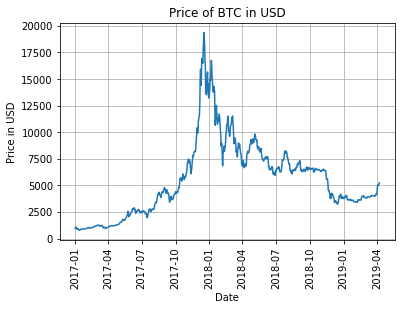

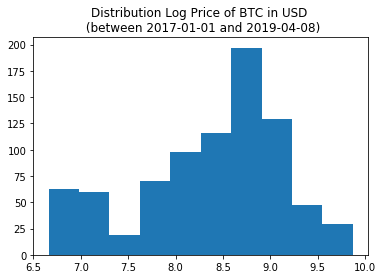

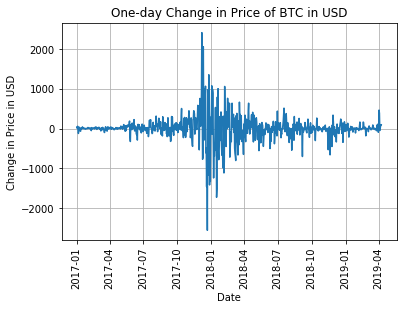

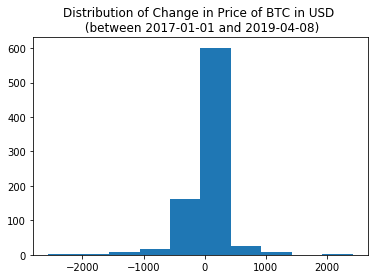

In [12]:
plot_twap(df, pair="btc/usd", start_date="2017-01-01")

Over this time frame, BTC doesn't appear to have the normal distribution of one-day price changes one would expect from a currency. Also, the day-to-day volitility seems first increase smoothly over time and then decrease smoothly. 

Over this time frame, BTC doesn't appear to have the normal distribution of one-day price changes one would expect from a currency. 

### Visualize the BitCoin data from 2017/02/01 to 2017/03/15

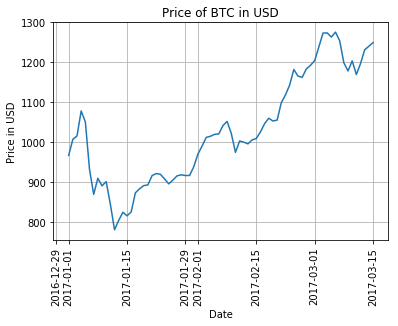

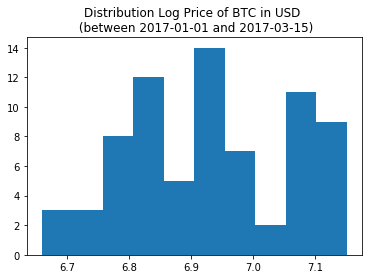

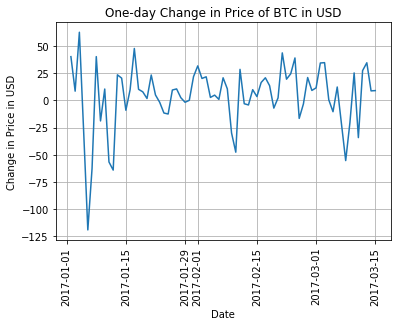

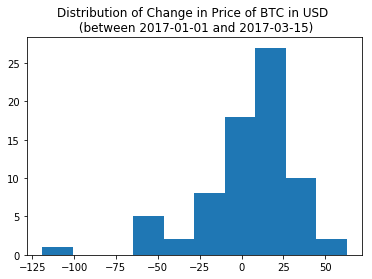

In [13]:
plot_twap(df, pair="btc/usd", start_date="2017-01-01", end_date="2017-03-15")

It has been proposed that after the crash, BTC may have stableized as a currency. The distribution of day-to-day changes appears closer to normal, but is still heavily skewed in this post-crash window.